In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt


bs = 64
# MNIST Dataset
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
for epoch in range(1, 21):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.220337
Train Epoch: 1 [6400/60000 (11%)]	Loss: 278.897461
Train Epoch: 1 [12800/60000 (21%)]	Loss: 284.333740
Train Epoch: 1 [19200/60000 (32%)]	Loss: 285.344971
Train Epoch: 1 [25600/60000 (43%)]	Loss: 279.578125
Train Epoch: 1 [32000/60000 (53%)]	Loss: 279.256134
Train Epoch: 1 [38400/60000 (64%)]	Loss: 264.626495
Train Epoch: 1 [44800/60000 (75%)]	Loss: 261.464630
Train Epoch: 1 [51200/60000 (85%)]	Loss: 256.113434
Train Epoch: 1 [57600/60000 (96%)]	Loss: 255.415192
====> Epoch: 1 Average loss: 279.9969
====> Test set loss: 269.6572
Train Epoch: 2 [0/60000 (0%)]	Loss: 269.814514
Train Epoch: 2 [6400/60000 (11%)]	Loss: 240.407028
Train Epoch: 2 [12800/60000 (21%)]	Loss: 258.770599
Train Epoch: 2 [19200/60000 (32%)]	Loss: 275.149780
Train Epoch: 2 [25600/60000 (43%)]	Loss: 250.565735
Train Epoch: 2 [32000/60000 (53%)]	Loss: 268.416229
Train Epoch: 2 [38400/60000 (64%)]	Loss: 239.487610
Train Epoch: 2 [44800/60000 (75%)]	Loss: 273.261566
Train Ep

Train Epoch: 15 [6400/60000 (11%)]	Loss: 239.486969
Train Epoch: 15 [12800/60000 (21%)]	Loss: 242.828949
Train Epoch: 15 [19200/60000 (32%)]	Loss: 258.641815
Train Epoch: 15 [25600/60000 (43%)]	Loss: 266.583923
Train Epoch: 15 [32000/60000 (53%)]	Loss: 246.639740
Train Epoch: 15 [38400/60000 (64%)]	Loss: 258.391174
Train Epoch: 15 [44800/60000 (75%)]	Loss: 254.937256
Train Epoch: 15 [51200/60000 (85%)]	Loss: 291.806763
Train Epoch: 15 [57600/60000 (96%)]	Loss: 249.832626
====> Epoch: 15 Average loss: 254.7676
====> Test set loss: 257.2149
Train Epoch: 16 [0/60000 (0%)]	Loss: 252.947525
Train Epoch: 16 [6400/60000 (11%)]	Loss: 269.440765
Train Epoch: 16 [12800/60000 (21%)]	Loss: 244.604630
Train Epoch: 16 [19200/60000 (32%)]	Loss: 235.631866
Train Epoch: 16 [25600/60000 (43%)]	Loss: 252.622025
Train Epoch: 16 [32000/60000 (53%)]	Loss: 240.158752
Train Epoch: 16 [38400/60000 (64%)]	Loss: 253.113617
Train Epoch: 16 [44800/60000 (75%)]	Loss: 255.772446
Train Epoch: 16 [51200/60000 (85%)]	L

In [8]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    
    sample = vae.decoder(z).cpu()
    
    #plt.imshow(sample.view(28,28), cmap='gray')
    save_image(sample.view(64, 1, 28, 28), './sample_2' +'.png')
    

In [9]:
import numpy as np
from scipy.stats import norm

nx = ny = 30
x_values = torch.linspace(0.05, 0.95, nx)
y_values = torch.linspace(0.05, 0.95, ny)
 
canvas = np.empty((28*ny, 28*nx))


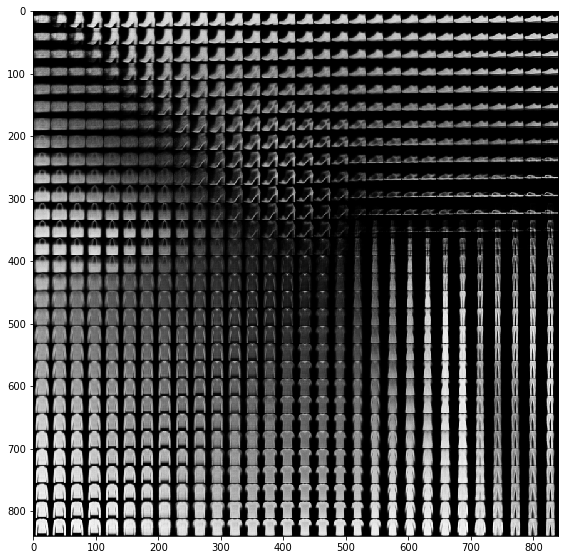

In [10]:
#manifold learning

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = torch.tensor(np.array([[norm.ppf(xi), norm.ppf(yi)]]).astype('float32'))
        x_mean = vae.decoder(z_mu.cuda()).cpu().detach().numpy()
        
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)
        
plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [11]:
test_x.size()

NameError: name 'test_x' is not defined

In [24]:
test_y.size()

torch.Size([10000])

In [12]:
import torchvision

test_data = torchvision.datasets.FashionMNIST(root='./data', train=False)

In [13]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [14]:
test_xx = test_data.test_data

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [15]:
test_xx.size()

torch.Size([10000, 28, 28])

In [17]:
test_xx1 = test_xx.reshape(10000,784).float()

In [18]:
z_mean1,_ = vae.encoder(test_xx1.cuda())
z_mean1 = z_mean1.cpu().detach().numpy()


In [19]:
y_test = test_data.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Text(0, 0.5, 'Dimension 2')

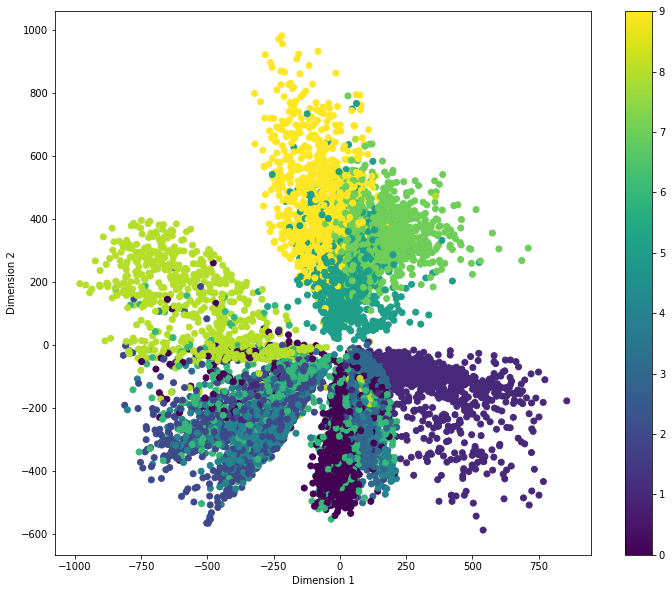

In [20]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean1[:, 0], z_mean1[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

#labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

In [21]:
for i,data in enumerate(test_loader,0):
    inputs = data[0]
    labels = data[1]

In [23]:
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

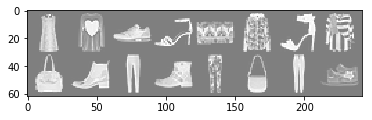

NameError: name 'classes' is not defined

In [24]:
imshow(torchvision.utils.make_grid(inputs.cpu()))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [27]:
inputs.size()
inputs = inputs.reshape(16,784)

In [30]:
inputs = inputs.cuda()

h_1 = vae.encoder(inputs)

z_2 = vae.sampling(h_1[0],h_1[1])

z_2.size()

sample_2 = vae.decoder(z_2).cpu()
sample_2.size()


torch.Size([16, 784])

In [34]:
sample_2 = sample_2.reshape(16,1,28,28)

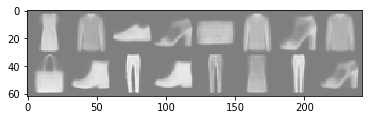

In [35]:
imshow(torchvision.utils.make_grid(sample_2.cpu()))